In [1]:
import numpy as np
import tqdm
from os import path
import random
import cv2
import math
from matplotlib import pyplot as plt
import pathlib
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.layers as L
import tensorflow.keras.regularizers as R
import tensorflow.keras.backend as B

In [2]:
import tensorflow as tf

print (tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2.3.1
Default GPU Device: /device:GPU:0


In [3]:
work_dir = "E:/Github/CoinsRecognition"

In [4]:
train_dir = path.join(work_dir, "Datasets/train")
test_dir = path.join(work_dir, "Datasets/test")

train_img_paths = [str(x).replace("\\", "/") for x in tqdm(pathlib.Path(train_dir).rglob('*.*'))]
test_img_paths = [str(x).replace("\\", "/") for x in tqdm(pathlib.Path(test_dir).rglob('*.*'))]

print(len(train_img_paths), len(test_img_paths))

6524it [00:03, 1707.51it/s]
844it [00:00, 935.56it/s]

6524 844


In [5]:
batch_size = 64
image_shape = (224, 224, 3)
num_classes = 211
epochs = 100

In [6]:
class ImagesExtractor():
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass
    
    @tf.function
    def _img_read_tf(self, file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img)
        label = tf.one_hot(tf.strings.to_number(tf.strings.split(file_path, '/')[-2], tf.int32) - 1, num_classes)
        return img, label
    
    @tf.function
    def _img_resize_tf(self, img, label):
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, image_shape[:2])
        return img, label
    
    def img_batch(self, file_paths, shuffle=0):
        AUTO = tf.data.experimental.AUTOTUNE
        res = tf.data.Dataset.from_tensor_slices(file_paths)
        if shuffle > 0:
            res = res.shuffle(shuffle)
        res = res.map(self._img_read_tf, num_parallel_calls=AUTO)
        res = res.map(lambda x, y: self._img_resize_tf(x, y), num_parallel_calls=AUTO)
        res = res.batch(batch_size) #.prefetch(AUTO)
        return res
    
    def img_iter(self, file_paths):
        AUTO = tf.data.experimental.AUTOTUNE
        res = tf.data.Dataset.from_tensor_slices(file_paths)
        res = res.map(self._img_read_tf, num_parallel_calls=AUTO)
        res = res.batch(1) #.prefetch(AUTO)
        return res
        
images_extractor = ImagesExtractor()

In [37]:
train_img_batch_generator = images_extractor.img_batch(train_img_paths, 2048)
#train_img_iter_generator = images_extractor.img_iter(train_img_paths)

test_img_batch_generator = images_extractor.img_batch(test_img_paths)
#test_img_iter_generator = images_extractor.img_iter(test_img_paths)


sample_img_paths = [path.join(train_dir, '37/2020-10-04_122500.png').replace("\\", "/"), 
                    path.join(train_dir, '37/2020-10-04_122447.png').replace("\\", "/"),
                    path.join(train_dir, '36/2020-10-04_121511.png').replace("\\", "/"), 
                    path.join(train_dir, '36/2020-10-04_121528.png').replace("\\", "/")]
sample_img_batch_generator = images_extractor.img_batch(sample_img_paths)
#sample_img_iter_generator = images_extractor.img_iter(sample_img_paths)

In [8]:
from functools import reduce

@tf.function
def aug_grid_mask(batch_tuple, d1=128, d2=224, ratio=0.5):
    img_batch, label_batch = batch_tuple
    batch_size, img_h, img_w = tf.shape(img_batch)[0], img_batch.shape[1], img_batch.shape[2]
    d = tf.random.uniform(shape=[batch_size, 1], minval=d1, maxval=d2, dtype=tf.int32) # (Batch Size, 1)
    d_f32 = tf.cast(d, tf.float32) # (Batch Size, 1)
    y_range = tf.reshape(tf.range(img_h), (1, -1)) + tf.cast(tf.random.uniform(shape=[batch_size, 1], dtype=tf.float32) * d_f32 - 1, tf.int32)# (Batch Size, IMG_H)
    x_range = tf.reshape(tf.range(img_w), (1, -1)) + tf.cast(tf.random.uniform(shape=[batch_size, 1], dtype=tf.float32) * d_f32 - 1, tf.int32) # (Batch Size, IMG_W)
    y_range = tf.expand_dims(tf.cast(y_range % d, tf.float32) / d_f32 >= ratio, axis=2) # (Batch Size, IMG_H, 1)
    x_range = tf.expand_dims(tf.cast(x_range % d, tf.float32) / d_f32 >= ratio, axis=1) # (Batch Size, 1, IMG_W)
    mask = tf.expand_dims(tf.math.logical_and(y_range, x_range) == False, axis=-1) # (Batch Size, IMG_H, IMG_W, 1)
    img_batch =  tf.where(mask, img_batch, 0)
    return (img_batch, label_batch)

@tf.function
def aug_affine(batch_tuple, rotation=360, shear=15, zoom=[0.7, 1.1], shift=[-16, 16], flip=3):
    img_batch, label_batch = batch_tuple
    batch_shape, batch_size, img_h, img_w = tf.shape(img_batch), tf.shape(img_batch)[0], img_batch.shape[1], img_batch.shape[2]
    # returns 3x3 transformmatrix which transforms indicies
    # CONVERT
    one = tf.ones([batch_size, 1], dtype='float32') # (Batch Size, 1)
    zero = tf.zeros([batch_size, 1], dtype='float32') # (Batch Size, 1)
    m_list = []
    if rotation != 0:
        rotation = math.pi * tf.random.uniform(shape=[batch_size, 1], minval=-rotation, maxval=rotation) / 180. # (Batch Size, 1)
        c1 = tf.math.cos(rotation) # (Batch Size, 1)
        s1 = tf.math.sin(rotation) # (Batch Size, 1)
        rotation_matrix = tf.concat([c1, s1, zero, -s1, c1, zero, zero, zero, one], axis=-1) # (Batch Size, 9)
        rotation_matrix = tf.reshape(rotation_matrix, [-1, 3, 3]) # (Batch Size, 3, 3)
        #m = rotation_matrix if (m is None) else B.batch_dot(m, rotation_matrix)
        m_list.append(rotation_matrix)
    if shear != 0:
        shear = math.pi * tf.random.uniform(shape=[batch_size, 1], minval=-shear, maxval=shear) / 180.       # (Batch Size, 1)
        c2 = tf.math.cos(shear) # (Batch Size, 1)
        s2 = tf.math.sin(shear) # (Batch Size, 1)
        shear_matrix = tf.concat([one, s2, zero, zero, c2, zero, zero, zero, one], axis=-1) # (Batch Size, 9)
        shear_matrix = tf.reshape(shear_matrix, [-1, 3, 3]) # (Batch Size, 3, 3)
        #m = shear_matrix if (m is None) else B.batch_dot(m, shear_matrix)
        m_list.append(shear_matrix)
    if zoom[0] != 1 or zoom[1] != 1:
        width_zoom = tf.random.uniform(shape=[batch_size, 1], minval=zoom[0], maxval=zoom[1]) # (Batch Size, 1)
        height_zoom = tf.random.uniform(shape=[batch_size, 1], minval=zoom[0], maxval=zoom[1]) # (Batch Size, 1)
        zoom_matrix = tf.concat([one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero, zero, one], axis=-1) # (Batch Size, 9)
        zoom_matrix = tf.reshape(zoom_matrix, [-1, 3, 3]) # (Batch Size, 3, 3)
        m_list.append(zoom_matrix)
    if shift[0] != 0 or shift[1] != 0:
        height_shift = tf.random.uniform(shape=[batch_size, 1], minval=shift[0], maxval=shift[1]) # (Batch Size, 1)
        width_shift = tf.random.uniform(shape=[batch_size, 1], minval=shift[0], maxval=shift[1]) # (Batch Size, 1)
        shift_matrix = tf.concat([one, zero, height_shift, zero, one, width_shift, zero, zero, one], axis=-1)
        shift_matrix = tf.reshape(shift_matrix, [-1, 3, 3]) # (Batch Size, 3, 3)
        m_list.append(shift_matrix)
    if flip != 0:
        # 1: left_right 2: up_down 3: both
        flip_y = tf.where(tf.random.uniform(shape=[batch_size, 1]) >= (0.5 if (flip == 1 or flip == 3) else 0), 1., -1.)
        flip_x = tf.where(tf.random.uniform(shape=[batch_size, 1]) >= (0.5 if (flip == 2 or flip == 3) else 0), 1., -1.)
        flip_matrix = tf.concat([flip_y, zero, zero, zero, flip_x, zero, zero, zero, one], axis=-1)
        flip_matrix = tf.reshape(flip_matrix, [-1, 3, 3]) # (Batch Size, 3, 3)
        #m = flip_matrix if (m is None) else B.batch_dot(m, flip_matrix)
        m_list.append(flip_matrix)
    if len(m_list) > 0:
        # MERGE MATRIX
        m_list = tf.unstack(tf.random.shuffle(tf.stack(m_list, axis=0)), axis=0) # List of (Batch Size, 3, 3)
        m = reduce((lambda x, y: B.batch_dot(x, y)), m_list)
        # LIST DESTINATION PIXEL INDICES
        
        x, y = tf.meshgrid(tf.range(img_w//2, -img_w//2, -1), tf.range(-img_h//2, img_h//2, 1)) # (Img_h, Img_w)
        x, y = tf.reshape(x, [-1]), tf.reshape(y, [-1])

        z = tf.ones([img_h * img_w], tf.int32) # (IMG_H * IMG_W)
        idx = tf.stack([x, y, z])              # (3, IMG_H * IMG_W)
        idx = tf.expand_dims(idx, axis=0)  # (1, 3, IMG_H * IMG_W)

        # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
        idx = tf.cast(B.batch_dot(m, tf.cast(idx, tf.float32)), tf.int32) # (Batch Size, 3, IMG_H * IMG_W)
        x_idx, y_idx = idx[:,0,:], idx[:,1,:]
        x_idx_valid = tf.math.logical_and(-img_w//2 + img_w%2 + 1 <= x_idx, x_idx <= img_w//2) # (Batch Size, IMG_H * IMG_W)
        y_idx_valid = tf.math.logical_and(-img_h//2 + img_h%2 + 1 <= y_idx, y_idx <= img_h//2) # (Batch Size, IMG_H * IMG_W)
        idx_valid = tf.math.logical_and(x_idx_valid, y_idx_valid) # # (Batch Size, IMG_H * IMG_W)
        x_idx = tf.where(x_idx_valid, x_idx, 0)
        y_idx = tf.where(y_idx_valid, y_idx, 0)
        # FIND ORIGIN PIXEL VALUES           
        idx = tf.stack([img_h//2-1+y_idx, img_w//2-x_idx],axis=-1) # (Batch Size, IMG_H * IMG_W, 2)
        img_batch = tf.gather_nd(img_batch, idx, batch_dims=1) # (Batch Size, IMG_H * IMG_W, 3)
        img_batch = tf.where(tf.expand_dims(idx_valid, axis=-1), img_batch, 0)
        img_batch = tf.reshape(img_batch, batch_shape)
    return (img_batch, label_batch)

@tf.function
def aug_color(batch_tuple, gaussian_s=0.01, hue_s=0.00, bright_s=0.1):
    img_batch, label_batch = batch_tuple
    
    if gaussian_s > 0:
        img_batch = img_batch + (gaussian_s * tf.random.normal(tf.shape(img_batch), mean=0.0, stddev=1., dtype=tf.float32))
        img_batch = tf.clip_by_value(img_batch, 0., 1.)
    
    if hue_s > 0:
        img_batch = tf.image.random_hue(img_batch, hue_s)
        img_batch = tf.clip_by_value(img_batch, 0., 1.)
    
    if bright_s > 0:
        img_batch = tf.image.random_brightness(img_batch, bright_s)
        img_batch = tf.clip_by_value(img_batch, 0., 1.)
    return (img_batch, label_batch)

@tf.function
def aug_mix(batch_tuple1, batch_tuple2, p):
    (img_batch1, label_batch1), (img_batch2, label_batch2) = batch_tuple1, batch_tuple2
    p = tf.random.uniform(shape=[tf.shape(img_batch1)[0]], minval=0, maxval=1, dtype=tf.float32) <= p
    img_batch = tf.where(tf.reshape(p, (-1, 1, 1, 1)), img_batch1, img_batch2)
    label_batch = tf.where(tf.reshape(p, (-1, 1)), label_batch1, label_batch2)
    return (img_batch, label_batch)
    
    
@tf.function
def datasets_augumentation(img_batch, label_batch):
    batch_tuple = (img_batch, label_batch)
    # Color
    #batch_tuple = aug_mix(aug_color(batch_tuple), batch_tuple, 0.7)

    # Affine 
    batch_tuple = aug_affine(batch_tuple)
    
    # Grid Mask
    batch_tuple = aug_mix(aug_grid_mask(batch_tuple), batch_tuple, 0.5)

    img_batch, label_batch = batch_tuple
    return img_batch, label_batch

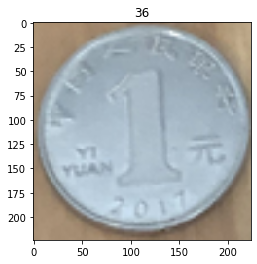

In [38]:
AUTO = tf.data.experimental.AUTOTUNE
train_datasets_format = train_img_batch_generator.map(datasets_augumentation, num_parallel_calls=AUTO).prefetch(AUTO)
test_datasets_format = test_img_batch_generator.prefetch(AUTO)
sample_datasets_format = sample_img_batch_generator.prefetch(AUTO)

for x, y_true in train_datasets_format:
    for i in range(1):
        plt.title(np.argmax(y_true[i]))
        plt.imshow(x[i])
        plt.show()
    break

In [10]:
def cosineAnnealingWithWarmup(epochIdx):
    aMin, aMax = 1e-5, 5e-4
    warmupEpochs, stagnateEpochs, cosAnnealingEpochs = 10, 0, 100
    epochIdx = epochIdx % (warmupEpochs + stagnateEpochs + cosAnnealingEpochs)
    if(epochIdx < warmupEpochs):
        return aMin + (aMax - aMin) / (warmupEpochs - 1) * epochIdx
    else:
        epochIdx -= warmupEpochs
    if(epochIdx < stagnateEpochs):
        return aMax
    else:
        epochIdx -= stagnateEpochs
    return aMin + 0.5 * (aMax - aMin) * (1 + math.cos((epochIdx + 1) / (cosAnnealingEpochs + 1) * math.pi))

#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=0.5, mode='auto')
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(tf.keras.experimental.CosineDecayRestarts(5e-5, 10), verbose=1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(cosineAnnealingWithWarmup, verbose=1)

In [11]:
class CosineLayer(L.Layer):
    def __init__(self, n_classes=num_classes, regularizer=None, **kwargs): 
        super().__init__(**kwargs)
        self.n_classes = n_classes
        self.regularizer = R.get(regularizer)

    def build(self, input_shape): 
        super().build(input_shape)
        # tf.constant_initializer(embedding_parms)
        # initializer='glorot_uniform'
        channel_cnt = 1
        self.W = self.add_weight(name='W', shape=(channel_cnt, input_shape[-1], self.n_classes), initializer='glorot_uniform', trainable=True, regularizer=self.regularizer)
        
    def call(self, x):
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1) # (Batch Size, Embedding_Dims)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=1) # (2, Embedding_Dims, Num_Class)
        
        logits = tf.map_fn(lambda w: tf.matmul(x, w), W)
        logits = tf.math.reduce_max(logits, axis=0)

        # a·b = |a|×|b|×cos<a,b> => cos<a,b> = (a/|a|)·(b/|b|)
        #logits = tf.matmul(x, W) # (None, 512) (512, 10, 2) (None, 10)
        return logits

In [12]:
def ClassificationMetric(y_true, y_pred):
    # y_pred = tf.nn.softmax(y_pred)  # (Batch Size, 10)
    y_pred_idxs = tf.cast(tf.math.argmax(y_pred, -1), tf.int32) # (Batch Size)
    y_true_idxs = tf.cast(tf.math.argmax(y_true, -1), tf.int32) # (Batch Size)
    # print(y_pred_idxs, y_pred_score, y_true)
    
    return tf.reduce_sum(tf.cast(y_pred_idxs == y_true_idxs, tf.float32)) / (tf.cast(tf.shape(y_pred_idxs)[0], tf.float32))

In [13]:
def ArcFaceLoss(m=0.50, s=30.0):
    def LossFunc(y_true, y_pred):
        theta = tf.acos(tf.clip_by_value(y_pred, -0.999999, 0.999999))
        y_pred_mod = tf.cos(tf.clip_by_value(theta + m, 0, np.pi))
        #
        y_pred = ((y_true) * y_pred_mod + (1 - y_true) * y_pred) * s

        loss = losses.CategoricalCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(y_true, y_pred)
        return loss
    return LossFunc

In [14]:
def CircleLoss(margin = 0.25, gamma=256):
    def LossFunc(y_true, y_pred):
        O_p = 1 + margin
        O_n = - margin
        Delta_p = 1 - margin
        Delta_n = margin

        alpha_p = tf.nn.relu(O_p - tf.stop_gradient(y_pred))
        alpha_n = tf.nn.relu(tf.stop_gradient(y_pred) - O_n)

        y_pred = ((y_true) * (alpha_p * (y_pred - Delta_p)) + (1 - y_true) * (alpha_n * (y_pred - Delta_n))) * gamma

        # Weighted Loss
        loss = losses.CategoricalCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(y_true, y_pred)
        return loss
    return LossFunc

In [15]:
MetricLearningType = "Circle"
MetricLearningLayer = { "ArcFace": CosineLayer, "Circle": CosineLayer }[MetricLearningType]
MetricLearningLoss = { "ArcFace": ArcFaceLoss, "Circle": CircleLoss }[MetricLearningType]()
MetricLearningMetric = ClassificationMetric

In [16]:
def build_model():
    input = Input(shape=image_shape, name='Input')
    x = input
    #backbone = efn.EfficientNetB0(input_shape=image_shape, include_top=False, weights='imagenet')
    backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=image_shape, include_top=False, weights='imagenet')
    for layer in backbone.layers:
        layer.trainable = True  # trainable has to be false in order to freeze the layers

    x = backbone(x)
    x = L.GlobalAveragePooling2D(name='Gap')(x)
    
    x = L.Dropout(0.7, name="Dropout")(x)
    x = L.Dense(256, name='Dense', activation=None)(x)
    
    x = MetricLearningLayer(name='Final')(x)
    output = x

    model = Model(input, output, name='model')
    model.compile(optimizer=optimizers.Adam(1e-3), loss = MetricLearningLoss, metrics=MetricLearningMetric)
    #model.load_weights('***', by_name=True, skip_mismatch=True)
    model.summary()
    return model
    
model = build_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
Gap (GlobalAveragePooling2D) (None, 1280)              0         
_________________________________________________________________
Dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
Dense (Dense)                (None, 256)               327936    
_________________________________________________________________
Final (CosineLayer)          (None, 211)               54016     
Total params: 2,639,936
Trainable params: 2,605,824
Non-trainable params: 34,112
______________________________________________

In [17]:
class timeout_check(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        loss, accuracy = self.model.evaluate(test_datasets_format) #, steps=4)
        self.model.save_weights(path.join(work_dir, "model_{:.0f}_{:.4f}_{:.4f}_{:.5f}.h5").format(float(epoch + 1), loss, accuracy, self.model.optimizer.learning_rate.numpy()))

In [ ]:
callbacks_list = [lr_schedule, timeout_check()]
#model.load_weights(path.join(work_dir, "model_6_132.2049_0.0692_0.00028.h5"))
history = model.fit(train_datasets_format, epochs=epochs, callbacks=callbacks_list) #, steps_per_epoch=25)

In [ ]:
epoch_idxs = np.arange(len(history.history["loss"])) + 1
lines_visualization((epoch_idxs, epoch_idxs), 
                    (history.history["metric_mIOU"], history.history["val_metric_mIOU"]), 
                    lines_label=("Train", "Valid"), 
                    xlabel="Epoch Idx", ylabel="mIOU", title="Training Process", dpi=100)
del epoch_idxs

In [28]:
class L2NormLayer(L.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass

    def call(self, inputs: tf.Tensor, **kwargs):
        inputs = tf.math.l2_normalize(inputs, axis=1)
        return inputs

In [29]:
def MetricLearningModel(name=None):
    input = Input(shape=image_shape, name='Input')
    #backbone = efn.EfficientNetB0(input_shape=image_shape, include_top=False, weights='imagenet')
    backbone = tf.keras.applications.MobileNetV2(input_shape=image_shape, include_top=False, weights='imagenet')
    x = backbone(input)
    x = L.GlobalAveragePooling2D(name='Gap')(x)

    x = L.Dense(256, name='Dense', activation=None)(x)
    x = L2NormLayer(name="L2")(x)
    output = x
    model = Model(input, output, name=name)
    #model.summary()
    return model

In [32]:
class GlobalFeatureExtractor():
    def __init__(self, model):
        self.model = MetricLearningModel("Backbone")
        self.model.load_weights(path.join(work_dir, "model_77_41.7805_0.8527_0.00013.h5"), by_name=True, skip_mismatch=True)
        self.model.summary()
    
    def extract_features(self, img_generator, steps=None):
        return self.model.predict(img_generator, verbose=1, steps=steps)

    @tf.function
    def _cos_similarity_iter(self, embedding_target, embedding_sources, k):
        distances = tf.matmul(embedding_sources, tf.expand_dims(embedding_target, axis=-1))[:,0] # (#embedding_sources)
        nearset_distances, nearest_idxs = tf.math.top_k(distances, k=k, sorted=True)
        nearset_distances, nearest_idxs = tf.cast(nearset_distances, tf.float32), tf.cast(nearest_idxs, tf.float32)
        return tf.stack([nearest_idxs, nearset_distances], axis=1) #(3, 2)
    
    @tf.function
    def cos_similarity(self, embedding_targets, embedding_sources, k):
        return tf.map_fn(lambda x: self._cos_similarity_iter(x, embedding_sources, k), embedding_targets, parallel_iterations=8) #(?, 3, 2)
    

global_feature_extractor = GlobalFeatureExtractor(model)

Model: "Backbone"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
Gap (GlobalAveragePooling2D) (None, 1280)              0         
_________________________________________________________________
Dense (Dense)                (None, 256)               327936    
_________________________________________________________________
L2 (L2NormLayer)             (None, 256)               0         
Total params: 2,585,920
Trainable params: 2,551,808
Non-trainable params: 34,112
_________________________________________________________________


In [39]:
global_feature_extractor.extract_features(sample_img_batch_generator)
sample_img_features = global_feature_extractor.extract_features(sample_img_batch_generator, 1)
print(global_feature_extractor.cos_similarity(sample_img_features, sample_img_features, 4))

1/1 [==============================] - 0s 5ms/step
tf.Tensor(
[[[0.         1.        ]
  [1.         0.9983433 ]
  [2.         0.06614216]
  [3.         0.04988864]]

 [[1.         1.        ]
  [0.         0.9983433 ]
  [2.         0.07075746]
  [3.         0.05389947]]

 [[2.         1.        ]
  [3.         0.98927826]
  [1.         0.07075746]
  [0.         0.06614216]]

 [[3.         0.99999994]
  [2.         0.98927826]
  [1.         0.05389947]
  [0.         0.04988864]]], shape=(4, 4, 2), dtype=float32)
